In [38]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import arviz as az
import pandas as pd
import xarray as xr
import seaborn as sns
sns.set_style("white")

In [39]:
fname="../DATA/BenPhyda/ensphyda/soilmoist/ensphyda_swna_pdsi_scaled_detrend.csv"
csvdata=pd.read_csv(fname)
year=csvdata.values[:,0]
data=csvdata.values[:,1:]
soilmoisture=xr.DataArray(data,dims=("year","ens"),coords={"year":year,"ens":np.arange(100)+1})

In [40]:
pi_period=(800,1850)
recent_period=(1850,2000)

In [41]:
idata_ar_ens=az.from_netcdf("posteriors.nc")


In [42]:
sm_preds=az.from_netcdf("predictions.nc")

In [43]:
def get_color(index):
    C={}
    C["nino"]=cm.tab10(0)
    C["amo"]=cm.tab10(1)
    C["pdo"]=cm.tab10(2)
    C["gmt"]=cm.tab10(5)
    return C[index]

# Posteriors
Plot the posterior distributions for the lag-1 and lag-2 correlations, white noise, and regression coefficients for SST indices

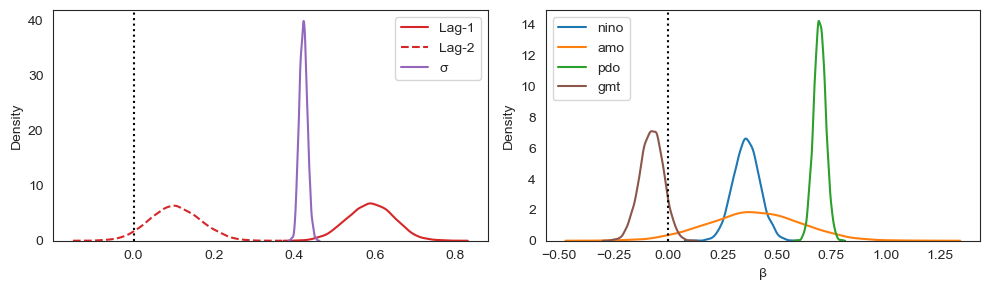

In [44]:
indices=["nino","amo","pdo","gmt"]
plt.figure(figsize=(10,3))
plt.subplot(122)
import seaborn as sns
for index in indices:
    sns.kdeplot(getattr(idata_ar_ens.posterior,"beta_"+index).stack(samples=("chain","draw")),label=index,color=get_color(index))
plt.legend(ncol=1,loc="upper left")
plt.xlabel("β")
plt.axvline(0,ls=":",c="k")

plt.subplot(121)
sns.kdeplot(idata_ar_ens.posterior.lag_coefs.sel(lags=-1).stack(samples=("chain","draw")),color=cm.tab10(3),label="Lag-1")
sns.kdeplot(idata_ar_ens.posterior.lag_coefs.sel(lags=-2).stack(samples=("chain","draw")),color=cm.tab10(3),ls="--",label="Lag-2")
sns.kdeplot(idata_ar_ens.posterior.sigma.stack(samples=("chain","draw")),color=cm.tab10(4),label="σ")
plt.legend()
plt.axvline(0,ls=":",c="k")
plt.tight_layout()
plt.savefig("../Figs/BEN/posteriors.pdf")

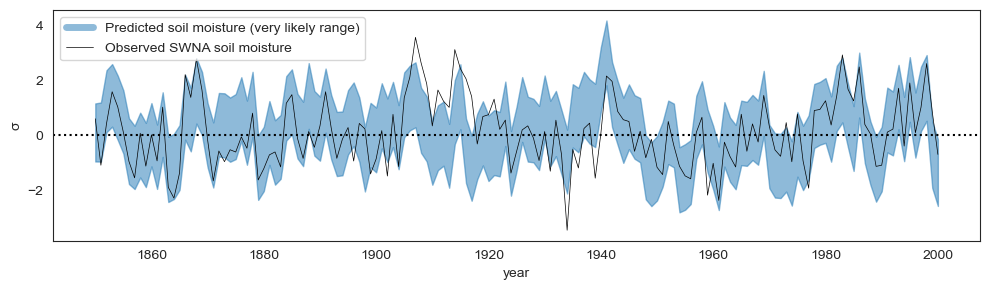

In [45]:
year_recent = idata_ar_ens.posterior.amo_recent.year_recent.values
plt.figure(figsize=(10,3))
#az.plot_hdi(pi_year,sm_preds.predictions.pi_sm,smooth=False)
#soilmoisture.mean(dim="ens").plot()
az.plot_hdi(year_recent,sm_preds.predictions.recent_sm,smooth=False,hdi_prob=.90,color=cm.tab10(0))
#dummy line for the legend
line,=plt.plot(year_recent,np.zeros_like(year_recent),lw=5,color=cm.tab10(0),alpha=.5,label="Predicted soil moisture (very likely range)")
soilmoisture.sel(year=slice(*recent_period)).mean(dim="ens").plot(label="Observed SWNA soil moisture",c="k",lw=.5,)
plt.legend()  
line.set_visible(False)
plt.axhline(0,ls=":",c="k")
plt.ylabel("σ")
plt.tight_layout()
plt.savefig("../Figs/BEN/predictions.pdf")

In [27]:
def posteriormean(x):
    return x.mean(dim=("chain","draw"))


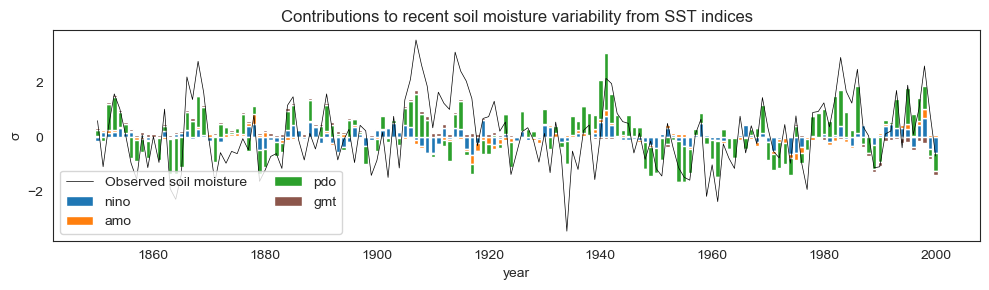

In [46]:
plt.figure(figsize=(10,3))
T=year_recent
posbottom=np.zeros_like(T)
negbottom=np.zeros_like(T)
for index in indices:
    just_exp=posteriormean(getattr(sm_preds.predictions,index+"_response_recent"))
    plt.bar(T,just_exp,bottom=np.where(just_exp>0,posbottom,negbottom),label=index,color=get_color(index))
    posbottom=np.where(just_exp>0,posbottom+just_exp,posbottom)
    negbottom=np.where(just_exp<0,negbottom+just_exp,negbottom)

soilmoisture.sel(year=slice(*recent_period)).mean(dim="ens").plot(c="k",lw=.5,label="Observed soil moisture")
plt.legend(ncol=2)
plt.title("Contributions to recent soil moisture variability from SST indices")
tmp=plt.ylabel("σ")
plt.tight_layout()
#plt.savefig("Figs/bars.png")
plt.savefig("../Figs/BEN/barchart.pdf")